In [86]:
import psycopg2
import pandas as pd
import numpy as np
import mariadb
import json
import os
import shutil
import subprocess
from pathlib import Path
import pyodbc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import pickle
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [87]:
analysisDetails = pd.read_csv("output/analysis_chemicals.csv")

In [88]:
analysisDetails.analysis_name = [ i.replace(":","") for i in analysisDetails.analysis_name ]

In [89]:
analysisDetails['chemical_name'] = [ i.replace("'","").replace("[","").replace("]","").split(",") for i in analysisDetails['chemical_name'] ]

In [90]:
analysisDetails = analysisDetails.set_index("analysis_name")

In [91]:
analysisDetails = analysisDetails.to_dict()['chemical_name']

In [92]:
analysisDetails['Basic Drinking Water Analysis'] = analysisDetails['Basic Drinking Water Analysis (WHO)'] 

In [93]:
analysisDetails

{'% Gypsum': ['%_gypsum'],
 '% Nitrogen (RSSP 2)': ['total_nitrogen'],
 '% Organic Matter': ['organic_matter'],
 '% Organic Matter (RSSP 2)': ['organic_matter'],
 '% Soil Nitrogen': ['total_nitrogen'],
 '%Assay': ['%assay', ' %assay'],
 '%N (RSSP 2)': ['total_nitrogen'],
 '%OM (RSSP 2)': ['organic_matter'],
 '%P,%S Analysis(Super Calcium)': ['sulphur',
  ' sulphur',
  ' sulphur',
  ' phosphorus',
  ' phosphorus',
  ' phosphorus'],
 '12 Soil Volume Extract': ['potassium',
  ' ph',
  ' calcium',
  ' sodium',
  ' magnesium',
  ' sulphur',
  ' manganese',
  ' copper',
  ' boron',
  ' zinc',
  ' molybdenum',
  ' iron',
  ' phosphorus',
  ' chloride',
  ' bicarbonate',
  ' nitrates',
  ' nitrate_n',
  ' ammonium',
  ' electrical_conductivity',
  ' silicon__'],
 '12 Soil Volume Extract (Data Only)': ['potassium',
  ' ph',
  ' calcium',
  ' sodium',
  ' magnesium',
  ' sulphur',
  ' manganese',
  ' copper',
  ' boron',
  ' zinc',
  ' molybdenum',
  ' iron',
  ' phosphorus',
  ' chloride',
  ' 

In [94]:
water_df = pd.read_csv("output/water_analysis_cleaned.csv")

In [95]:
water_df.analysis_name.unique()

array(['Standard Drinking Water Analysis (WHO)',
       'Irrigation Water Analysis (FAO)',
       'Standard Drinking Water Analysis',
       'Basic Drinking Water Analysis', 'Reverse Osmosis Water Use',
       'Basic Drinking Water Analysis (WHO)', 'Heavy Metals in Water',
       'Base Titanium Water Analysis', 'E coli & Total Coliforms',
       'Post Harvest Water Analysis', 'Total Suspended Solids',
       'Total Bacteria Count', 'Total Dissolved Solids',
       'KEBS Drinking Water Standard Analysis',
       'KEBS Drinking Water Microbiology',
       'Standard Drinking Water + Free Chlorine Analysis',
       'Turbidity Analysis', 'Feacal Coliforms (MPN) and E.Coli',
       'Total Coliforms and Faecal E.Coli', 'Water Colour Analysis',
       'Taita Water Analysis (Uni of Helsinki)', 'WRMA Water Analysis',
       'Water Borne Diseases', 'Aquasearch Full Chemical Analysis',
       'Total Bacterial Count', 'Legionella', 'Alkalinity in Water',
       'E coli', 'KEBS Drinking Water Minimu

In [96]:
water_df.analysis_name.value_counts().to_csv("output/analysis_value_counts.csv")

In [97]:
water_df.analysis_name = [ str(i).strip() for i in water_df.analysis_name]

In [98]:
pd.DataFrame(water_df.unit_name.value_counts())

count
unit_name         
ppm         901592
mpn/100ml    42709
mS cm -1     31942
NTU          11531
cfu/ml        9840
cfu/100 ml    6645
in 100ml      3576
H.U           1512
uS/cm          222
mg/l            34
ug/l            24
cfu/100ml        8

In [99]:
water_df['analysis_name'] = [i.replace(":","") for i in water_df['analysis_name']]
water_df['result'] = [ float(str(i).replace("<","").replace(">","")) for i in water_df['result'] ]

In [100]:
# water_df.sort_values("batch_date")

In [101]:
# water_df = water_df.sort_values('sample_code')

In [102]:
water_df

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0               12499          8921          8921        8921   
1               16538         11427         11427       11427   
2               24488         16269         16269       16269   
3               25157         16767         16767       16767   
4               27641         18681         18681       18681   
...               ...           ...           ...         ...   
1019274         24600         16345         16345       16345   
1019275         91666         63166         63166       63166   
1019276         59853         40706         40706       40706   
1019277        342158        230285        230285      230285   
1019278        387512        258965        258965      258965   

               sample_code               batch_date  \
0              CC064WA0109  2023-05-24 14:19:00.000   
1              CP207WA0005  2020-05-18 10:41:03.000   
2              CK391WA0001  2020-05-18 11:53:00.000   
3        CH006WA1475        2020-09-23 12:21:00.000   
4              CM507WA0001  2020-05-18 15:55:00.000   
...                    ...                      ...   
1019274        CR027WA0186  2012-03-15 00:00:00.000   
1019275        CR027WA0039  2011-12-19 00:00:00.000   
1019276        CS001WA0005  2014-10-30 00:00:00.000   
1019277        CC003WA0072  2014-10-28 00:00:00.000   
1019278        CM170WA0022  2015-01-28 00:00:00.000   

                                  analysis_name    chemical_name  result  \
0        Standard Drinking Water Analysis (WHO)  total_coliforms     0.0   
1        Standard Drinking Water Analysis (WHO)  total_coliforms     0.0   
2        Standard Drinking Water Analysis (WHO)  total_coliforms     4.0   
3        Standard Drinking Water Analysis (WHO)  total_coliforms    26.0   
4        Standard Drinking Water Analysis (WHO)  total_coliforms   180.0   
...                                         ...              ...     ...   
1019274                           BTEX Analysis         toluene_     1.0   
1019275                           BTEX Analysis         toluene_     1.0   
1019276           Salmonella and E.Coli (Water)           e_coli     1.0   
1019277           Salmonella and E.Coli (Water)           e_coli     1.0   
1019278           Salmonella and E.Coli (Water)           e_coli    14.0   

          unit_name  
0         mpn/100ml  
1         mpn/100ml  
2         mpn/100ml  
3         mpn/100ml  
4         mpn/100ml  
...             ...  
1019274        ug/l  
1019275        ug/l  
1019276  cfu/100 ml  
1019277  cfu/100 ml  
1019278  cfu/100 ml  

[1019279 rows x 10 columns]

In [103]:
new_samples_df = water_df.loc[water_df['batch_date'] > '2024-05-21'] 


In [104]:
water_df = water_df.loc[water_df['batch_date'] <= '2024-05-21'] 

In [105]:
new_samples_df

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  sample_code  \
473            586504        397386        397386      397386  CB075WA0029   
479            588645        399047        399047      399047  CS333WA0516   
480            588746        399143        399143      399143  CS333WA0517   
1165          1141438        779152        779152      779152  CK022WA0841   
1811          1211328        832872        832872      832872  CK059WA0666   
...               ...           ...           ...         ...          ...   
1019080       1422751       1001127       1001135     1001135  CB278WA0013   
1019081       1422857       1001218       1001226     1001226  CB278WA0012   
1019083       1619712       1147470       1147478     1147478  CE022WA0148   
1019104       1635829       1159594       1159602     1159602  CD090WA0031   
1019105       1696355       1202855       1202863     1202863  CO119WA0060   

                      batch_date                           analysis_name  \
473      2024-07-09 15:07:43.640  Standard Drinking Water Analysis (WHO)   
479      2024-08-07 11:35:00.000  Standard Drinking Water Analysis (WHO)   
480      2024-08-07 11:37:22.000  Standard Drinking Water Analysis (WHO)   
1165     2024-05-30 16:36:00.000  Standard Drinking Water Analysis (WHO)   
1811     2024-10-02 15:10:11.000  Standard Drinking Water Analysis (WHO)   
...                          ...                                     ...   
1019080  2024-10-08 15:01:00.000                   Staphylococcus aureus   
1019081  2024-10-08 15:01:00.000                   Staphylococcus aureus   
1019083  2024-08-15 14:56:00.000                   Staphylococcus aureus   
1019104  2024-05-29 09:48:00.000                      Strontium Analysis   
1019105  2024-06-24 10:25:00.000                      Strontium Analysis   

                 chemical_name   result   unit_name  
473            total_coliforms    0.000   mpn/100ml  
479            total_coliforms  350.000   mpn/100ml  
480            total_coliforms   70.000   mpn/100ml  
1165           total_coliforms    0.000   mpn/100ml  
1811           total_coliforms    0.000   mpn/100ml  
...                        ...      ...         ...  
1019080  staphylococcus_aureus    0.000  cfu/100 ml  
1019081  staphylococcus_aureus    0.000  cfu/100 ml  
1019083  staphylococcus_aureus    0.000  cfu/100 ml  
1019104              strontium    0.064         ppm  
1019105              strontium    0.250         ppm  

[58553 rows x 10 columns]

In [106]:
water_df.analysis_name.value_counts().to_csv("output/modelling_analysis_value_counts.csv")
new_samples_df.analysis_name.value_counts().to_csv("output/test_analysis_value_counts.csv")

In [107]:
water_df['analysis_name'].nunique()

63

In [108]:
new_samples_df['analysis_name'].nunique()

37

In [109]:
new_samples_df[(new_samples_df['analysis_name'].isin(water_df['analysis_name'].unique()))].analysis_name.nunique()

36

In [110]:
water_df

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0               12499          8921          8921        8921   
1               16538         11427         11427       11427   
2               24488         16269         16269       16269   
3               25157         16767         16767       16767   
4               27641         18681         18681       18681   
...               ...           ...           ...         ...   
1019274         24600         16345         16345       16345   
1019275         91666         63166         63166       63166   
1019276         59853         40706         40706       40706   
1019277        342158        230285        230285      230285   
1019278        387512        258965        258965      258965   

               sample_code               batch_date  \
0              CC064WA0109  2023-05-24 14:19:00.000   
1              CP207WA0005  2020-05-18 10:41:03.000   
2              CK391WA0001  2020-05-18 11:53:00.000   
3        CH006WA1475        2020-09-23 12:21:00.000   
4              CM507WA0001  2020-05-18 15:55:00.000   
...                    ...                      ...   
1019274        CR027WA0186  2012-03-15 00:00:00.000   
1019275        CR027WA0039  2011-12-19 00:00:00.000   
1019276        CS001WA0005  2014-10-30 00:00:00.000   
1019277        CC003WA0072  2014-10-28 00:00:00.000   
1019278        CM170WA0022  2015-01-28 00:00:00.000   

                                  analysis_name    chemical_name  result  \
0        Standard Drinking Water Analysis (WHO)  total_coliforms     0.0   
1        Standard Drinking Water Analysis (WHO)  total_coliforms     0.0   
2        Standard Drinking Water Analysis (WHO)  total_coliforms     4.0   
3        Standard Drinking Water Analysis (WHO)  total_coliforms    26.0   
4        Standard Drinking Water Analysis (WHO)  total_coliforms   180.0   
...                                         ...              ...     ...   
1019274                           BTEX Analysis         toluene_     1.0   
1019275                           BTEX Analysis         toluene_     1.0   
1019276           Salmonella and E.Coli (Water)           e_coli     1.0   
1019277           Salmonella and E.Coli (Water)           e_coli     1.0   
1019278           Salmonella and E.Coli (Water)           e_coli    14.0   

          unit_name  
0         mpn/100ml  
1         mpn/100ml  
2         mpn/100ml  
3         mpn/100ml  
4         mpn/100ml  
...             ...  
1019274        ug/l  
1019275        ug/l  
1019276  cfu/100 ml  
1019277  cfu/100 ml  
1019278  cfu/100 ml  

[960726 rows x 10 columns]

In [111]:
water_df.result.info()

<class 'pandas.core.series.Series'>
Index: 960726 entries, 0 to 1019278
Series name: result
Non-Null Count   Dtype  
--------------   -----  
960726 non-null  float64
dtypes: float64(1)
memory usage: 14.7 MB


In [112]:
water_df.sort_values("result")

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
967988        1345796        942555        942563      942563   
967956        1331410        931135        931143      931143   
968239        1524807       1079337       1079345     1079345   
1002525       1376377        964232        964240      964240   
1002873       1737229       1231814       1231822     1231822   
...               ...           ...           ...         ...   
973214        1336025        934910        934918      934918   
975904        1336002        934888        934896      934896   
1015288        390177        260899        260899      260899   
1010257         90875         62519         62519       62519   
1011023         90875         62519         62519       62519   

               sample_code               batch_date  \
967988         CN083WA0167  2023-03-07 16:58:00.000   
967956         CS571WA0006  2023-03-06 12:40:00.000   
968239         CJ373WA0002  2023-09-27 11:10:00.000   
1002525  CB057WA2125        2022-02-17 18:37:00.000   
1002873  CB057WA2665        2024-04-24 16:36:00.000   
...                    ...                      ...   
973214         CB210WA0031  2021-12-03 16:08:00.000   
975904         CB210WA0031  2021-12-03 16:08:00.000   
1015288        CA014WA0027  2020-03-10 16:20:00.000   
1010257        CI022WA0020  2011-11-07 00:00:00.000   
1011023        CI022WA0020  2011-11-07 00:00:00.000   

                                 analysis_name      chemical_name  \
967988   KEBS Drinking Water Standard Analysis            nitrite   
967956   KEBS Drinking Water Standard Analysis            nitrite   
968239   KEBS Drinking Water Standard Analysis            nitrite   
1002525                    WRMA Water Analysis            nitrite   
1002873                    WRMA Water Analysis            nitrite   
...                                        ...                ...   
973214        KEBS Drinking Water Microbiology            tvc_@22   
975904        KEBS Drinking Water Microbiology            tvc_@37   
1015288       Selected elements (ICP) Analysis            calcium   
1010257                  Total Bacterial Count  tbc_at_37_degrees   
1011023                  Total Bacterial Count  tbc_at_37_degrees   

              result unit_name  
967988        -0.017       ppm  
967956        -0.013       ppm  
968239        -0.011       ppm  
1002525       -0.006       ppm  
1002873       -0.005       ppm  
...              ...       ...  
973214    490000.000    cfu/ml  
975904    500000.000    cfu/ml  
1015288   960000.000       ppm  
1010257  1900000.000    cfu/ml  
1011023  1900000.000    cfu/ml  

[960726 rows x 10 columns]

In [113]:
water_df['analysis_name'].value_counts()

analysis_name
Standard Drinking Water Analysis (WHO)    206971
Basic Drinking Water Analysis             164706
Standard Drinking Water Analysis          139065
Reverse Osmosis Water Use                 126002
Irrigation Water Analysis (FAO)           112983
                                           ...  
Staphylococcus aureus                         11
KS Potable Water Microbiology                 11
TPH Analysis                                   7
Salmonella and E.Coli (Water)                  3
Total Coliforms                                2
Name: count, Length: 63, dtype: int64

In [114]:
[ j.strip() for j in analysisDetails['BTEX Analysis'] ]

['benzene__', 'toluene_', 'xylene_', 'ethyl_benzene']

In [116]:
expected_vs_actual_chems_df = pd.DataFrame()
missing_analyses = []
for analysis in np.unique(water_df['analysis_name']):
    print(analysis)
    df_ = water_df.loc[water_df['analysis_name']==analysis]
    print(df_.chemical_name.unique())
    if analysis == "Standard Drinking Water Analysis (WHO)":
        chems_to_use = [ i.strip() for i in analysisDetails[analysis] if i.strip() !="faecal_e_coli"]
    elif analysis == "KEBS Drinking Water Microbiology":
        chems_to_use = [ i.strip() for i in analysisDetails[analysis] if i.strip() !="faecal_e_coli"]
    elif analysis == "Irrigation Water Analysis (FAO)":
        chems_to_use = [ i.strip() for i in analysisDetails[analysis] if i.strip() not in ['fluoride','silica']]
    elif analysis == "Heavy Metals in Water":
        chems_to_use = [ i.strip() for i in analysisDetails[analysis] if i.strip() not in ['aluminium']]
    else:
        chems_to_use = [ i.strip() for i in analysisDetails[analysis] ]
    df_ = pd.pivot_table(data=df_, values="result", index="sample_code", columns="chemical_name")
    print("Expected analyses",chems_to_use)
    print("Actual analyses",df_.columns)
    df_ = df_[[ j.strip() for j in chems_to_use if j.strip() in df_.columns]]
    df_ = df_.loc[:, ~df_.columns.duplicated()]
    os.makedirs(f"output/boxplots/{analysis}",exist_ok=True)
    for column in df_.columns:        
        plt.boxplot(df_[column])
        plt.savefig(f"output/boxplots/{analysis}/{column}.png")
        plt.clf()
        outlier_threshold = df_[column].quantile(0.99)
        # df_ = df_.loc[df_[column] <= outlier_threshold]
    if analysis not in analysisDetails.keys():
        missing_analyses.append(analysis)
        continue
    _ = pd.DataFrame({"analysis": analysis, "expected_chemicals": ",".join(analysisDetails[analysis]), "chemicals_checked" : df_.columns})
    if len(df_.columns) == 0:
        continue
    df_.describe().to_csv(f"output/chemical_null_count/{analysis}.csv")
    
    df_.to_csv(f"output/analysis/{analysis}.csv")


Aluminium analysis
['aluminium']
Expected analyses ['aluminium', 'aluminium']
Actual analyses Index(['aluminium'], dtype='object', name='chemical_name')
Aquasearch Full Chemical Analysis
['hardness' 'carbonate']
Expected analyses ['potassium', 'ph', 'calcium', 'sodium', 'magnesium', 'sulphur', 'manganese', 'copper', 'boron', 'zinc', 'iron', 'phosphorus', 'chloride', 'carbonate', 'bicarbonate', 'nitrates', 'nitrate_n', 'nitrite_n', 'ammonium', 'sulphate', 'total_dissolved_solids', 'turbidity', 'electrical_conductivity', 'calcium_carbonate', 'colour', 'aluminium', 'silicon__', 'total_suspended_solids', 'fluoride', 'silica', 'hardness', 'charge_balance_error']
Actual analyses Index(['carbonate', 'hardness'], dtype='object', name='chemical_name')
BT Extended Water Quality Analysis
['iron' 'ammonium' 'total_dissolved_solids' 'cadmium' 'aluminium'
 'chromium' 'lead' 'molybdenum' 'calcium' 'arsenic' 'potassium' 'hardness'
 'total_suspended_solids' 'magnesium' 'selenium' 'zinc' 'copper' 'bod'


<Figure size 640x480 with 0 Axes>

In [117]:
missing_analyses

[]

In [118]:
water_df = water_df.loc[water_df['batch_date'] <= '2024-05-21'] 

In [119]:
water_df

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0               12499          8921          8921        8921   
1               16538         11427         11427       11427   
2               24488         16269         16269       16269   
3               25157         16767         16767       16767   
4               27641         18681         18681       18681   
...               ...           ...           ...         ...   
1019274         24600         16345         16345       16345   
1019275         91666         63166         63166       63166   
1019276         59853         40706         40706       40706   
1019277        342158        230285        230285      230285   
1019278        387512        258965        258965      258965   

               sample_code               batch_date  \
0              CC064WA0109  2023-05-24 14:19:00.000   
1              CP207WA0005  2020-05-18 10:41:03.000   
2              CK391WA0001  2020-05-18 11:53:00.000   
3        CH006WA1475        2020-09-23 12:21:00.000   
4              CM507WA0001  2020-05-18 15:55:00.000   
...                    ...                      ...   
1019274        CR027WA0186  2012-03-15 00:00:00.000   
1019275        CR027WA0039  2011-12-19 00:00:00.000   
1019276        CS001WA0005  2014-10-30 00:00:00.000   
1019277        CC003WA0072  2014-10-28 00:00:00.000   
1019278        CM170WA0022  2015-01-28 00:00:00.000   

                                  analysis_name    chemical_name  result  \
0        Standard Drinking Water Analysis (WHO)  total_coliforms     0.0   
1        Standard Drinking Water Analysis (WHO)  total_coliforms     0.0   
2        Standard Drinking Water Analysis (WHO)  total_coliforms     4.0   
3        Standard Drinking Water Analysis (WHO)  total_coliforms    26.0   
4        Standard Drinking Water Analysis (WHO)  total_coliforms   180.0   
...                                         ...              ...     ...   
1019274                           BTEX Analysis         toluene_     1.0   
1019275                           BTEX Analysis         toluene_     1.0   
1019276           Salmonella and E.Coli (Water)           e_coli     1.0   
1019277           Salmonella and E.Coli (Water)           e_coli     1.0   
1019278           Salmonella and E.Coli (Water)           e_coli    14.0   

          unit_name  
0         mpn/100ml  
1         mpn/100ml  
2         mpn/100ml  
3         mpn/100ml  
4         mpn/100ml  
...             ...  
1019274        ug/l  
1019275        ug/l  
1019276  cfu/100 ml  
1019277  cfu/100 ml  
1019278  cfu/100 ml  

[960726 rows x 10 columns]

In [120]:
# for analysis_file in os.listdir("output/analysis"):
#     if f"{analysis_file.replace('.csv','')}.png" in os.listdir("./output/pairplots"):
#         continue
#     os.makedirs("./output/pairplots",exist_ok=True)
    
#     analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
#     print(analysis_file.replace('.csv',''))
#     sns.pairplot(analysis_df)
#     print('Saving')
#     plt.savefig(f"output/pairplots/{analysis_file.replace('.csv','')}.png")
#     print('Saved')
#     plt.clf()

In [121]:
os.makedirs("./output/analysis_imputed",exist_ok=True)
os.makedirs("./output/pca_plots",exist_ok=True)

Aluminium analysis.csv
Aquasearch Full Chemical Analysis.csv
Number of components explaining 95% variance: 2
Base Titanium Water Analysis.csv
Number of components explaining 95% variance: 10
Basic Drinking Water Analysis (WHO).csv
Number of components explaining 95% variance: 12
Basic Drinking Water Analysis.csv
Number of components explaining 95% variance: 15
Biological Oxygen Demand.csv
BT Extended Water Quality Analysis.csv
Number of components explaining 95% variance: 13
BTEX Analysis.csv
Number of components explaining 95% variance: 1
Chemical & Biochemical Oxygen Demand.csv
Number of components explaining 95% variance: 2


C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Chemical Oxygen Demand.csv
Clostridium Perfringens.csv
Colloidal Silica in Water.csv
E coli & Total Coliforms.csv
Number of components explaining 95% variance: 2
E coli.csv
Faecal E.Coli.csv
Feacal Coliforms (MPN) and E.Coli.csv
Number of components explaining 95% variance: 2
Fluoride in Water.csv
Number of components explaining 95% variance: 2
Heavy Metals in Water.csv
Number of components explaining 95% variance: 10
Iron in Water.csv
Irrigation Water Analysis (FAO).csv
Number of components explaining 95% variance: 12
KEBS Drinking Water Microbiology.csv
Number of components explaining 95% variance: 5
KEBS Drinking Water Min Monitoring Microbiology.csv
Number of components explaining 95% variance: 1
KEBS Drinking Water Minimum Monitoring.csv
Number of components explaining 95% variance: 2
KEBS Drinking Water Standard Analysis.csv
Number of components explaining 95% variance: 4
KS Potable Water Microbiology.csv
Legionella.csv
Number of components explaining 95% variance: 1
Listeria Ana

C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\tsuma.thomas\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Listeria monocytogens.csv
Manganese in Water.csv
Oil & Grease.csv
Post Harvest Water Analysis.csv
Number of components explaining 95% variance: 1
Raw irrigation water analysis (for fertigation).csv
Number of components explaining 95% variance: 6
Reagent Water Analysis.csv
Number of components explaining 95% variance: 2
Reverse Osmosis Water Use.csv
Number of components explaining 95% variance: 16


C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_32464\3517237295.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))


Salmonella and E.Coli (Water).csv
Salmonella spp.csv
Selected elements (ICP) Analysis.csv
Number of components explaining 95% variance: 2
Silver Analysis.csv
Silver in Water.csv
Standard Drinking Water + Free Chlorine Analysis.csv
Number of components explaining 95% variance: 4
Standard Drinking Water Analysis (WHO).csv
Number of components explaining 95% variance: 17
Standard Drinking Water Analysis.csv
Number of components explaining 95% variance: 10
Staphylococcus aureus.csv
Strontium Analysis.csv
Sulphur in Water.csv
Taita Water Analysis (Uni of Helsinki).csv
Number of components explaining 95% variance: 10
Total Bacteria Count.csv
Number of components explaining 95% variance: 2
Total Bacterial Count.csv
Number of components explaining 95% variance: 2
Total Coliforms and Faecal E.Coli.csv
Total Coliforms.csv
Total Dissolved Solids.csv
Total Suspended Solids.csv
Number of components explaining 95% variance: 2
Total Viable Count @30.csv
TPH Analysis.csv
Turbidity Analysis.csv
Turbidi

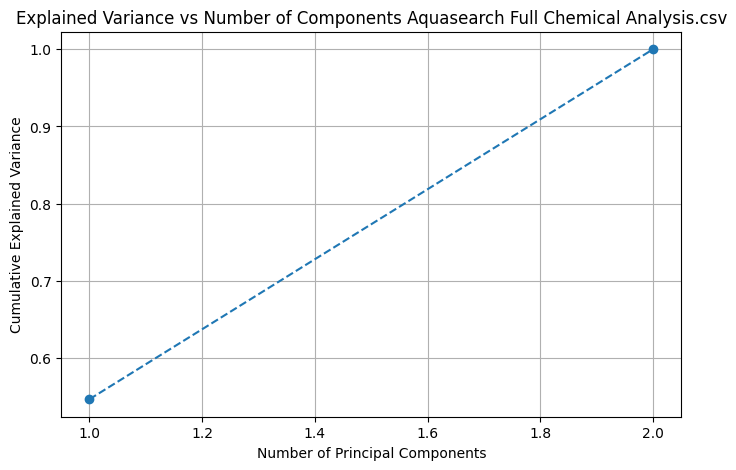

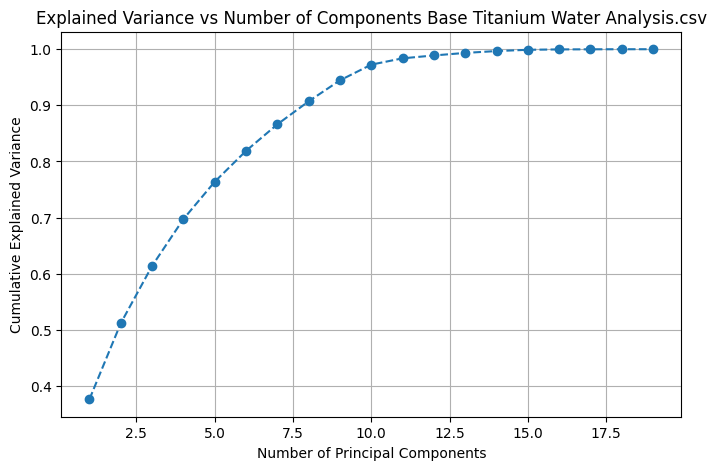

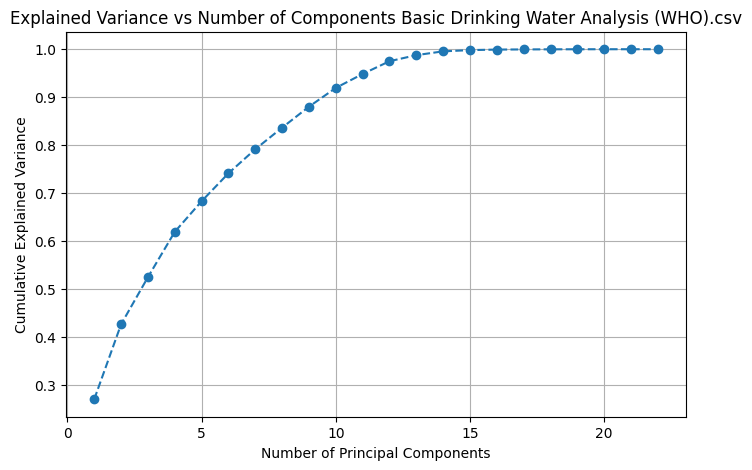

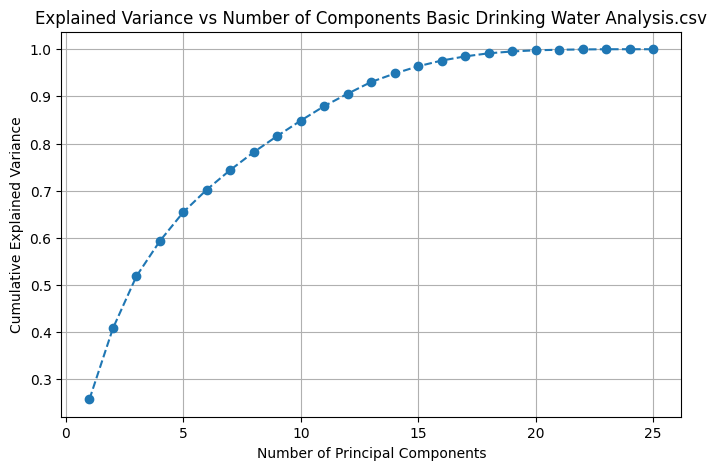

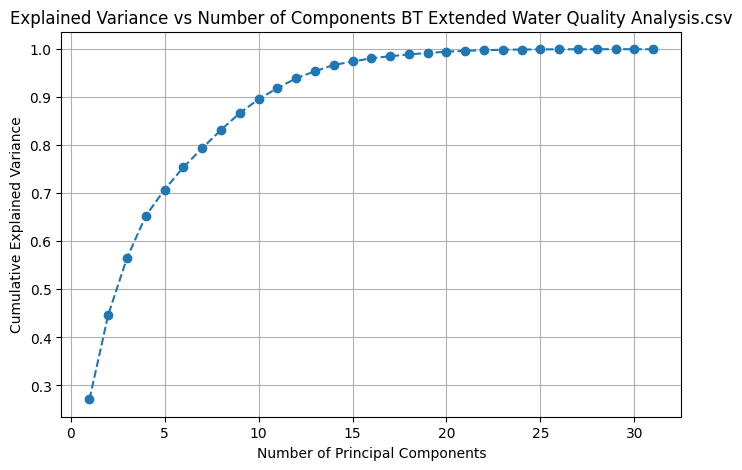

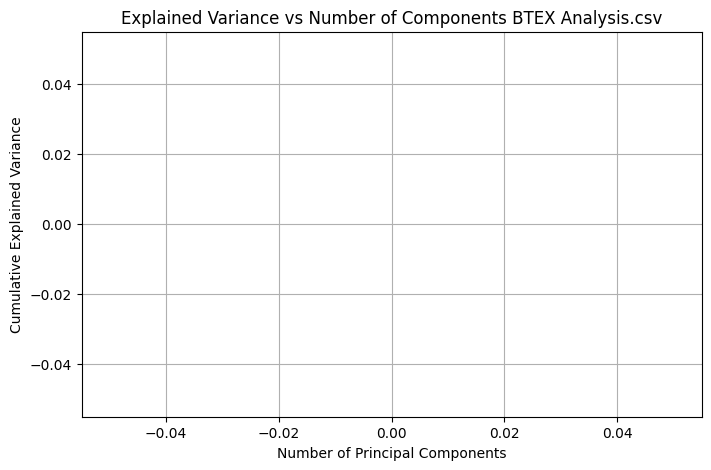

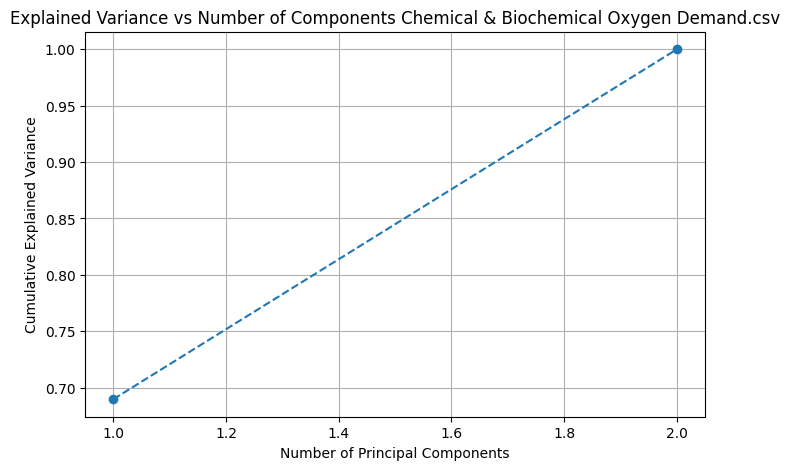

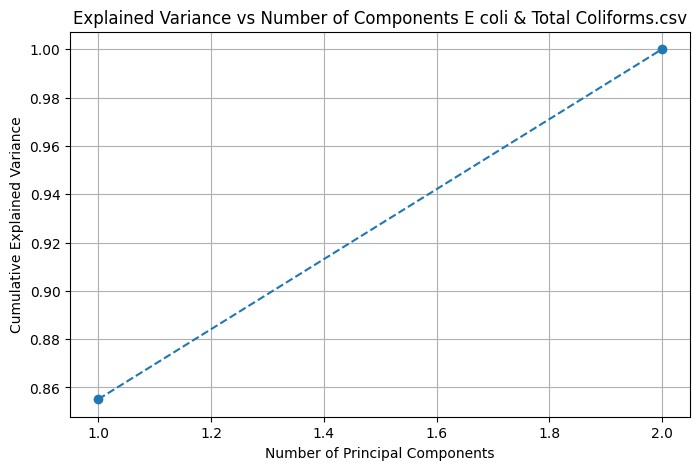

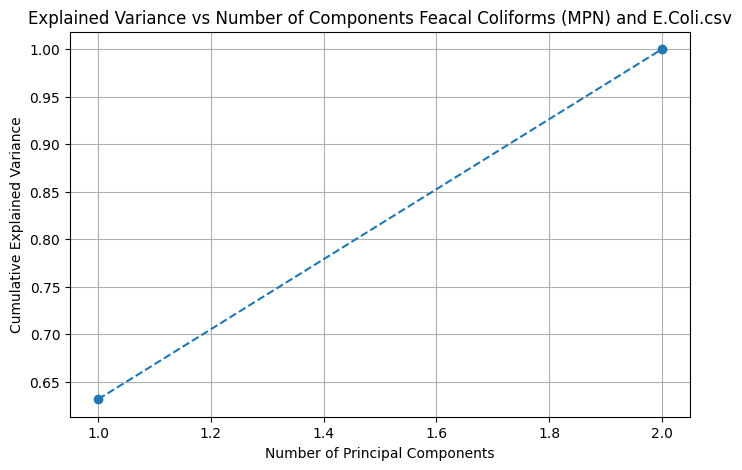

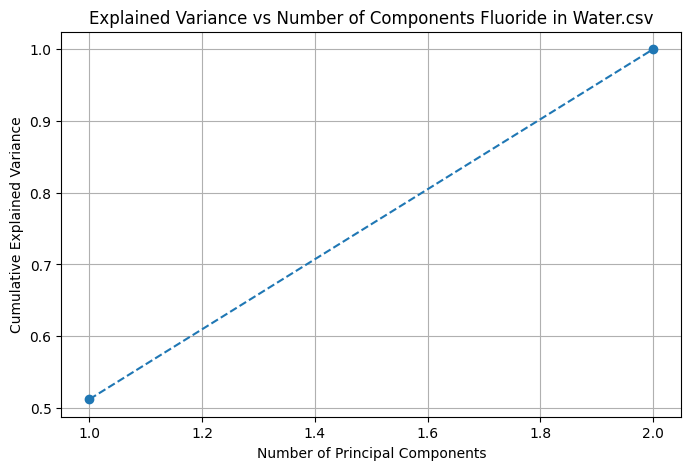

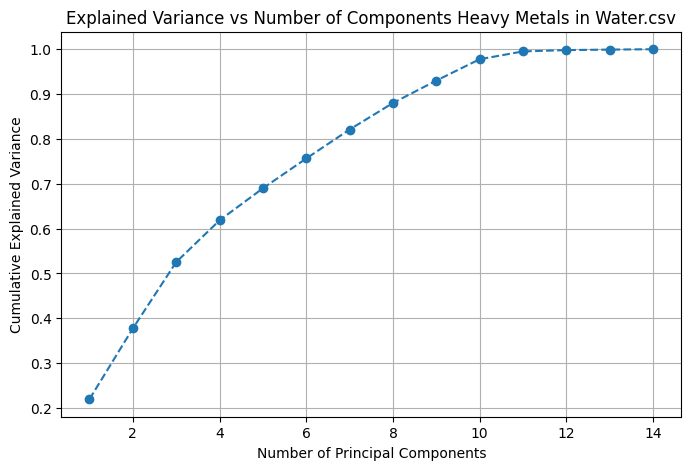

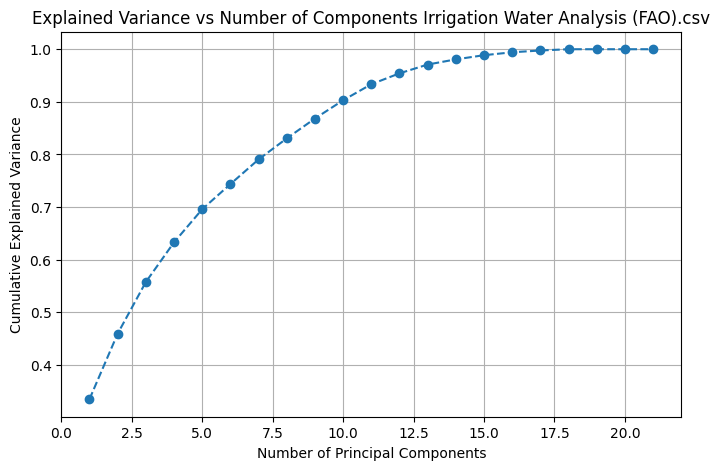

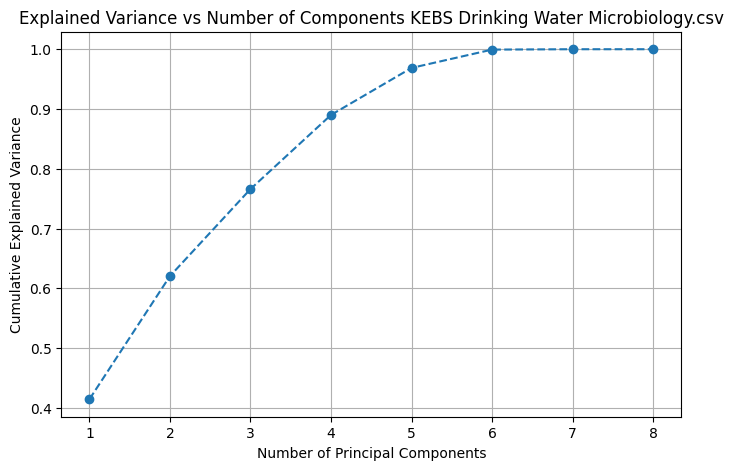

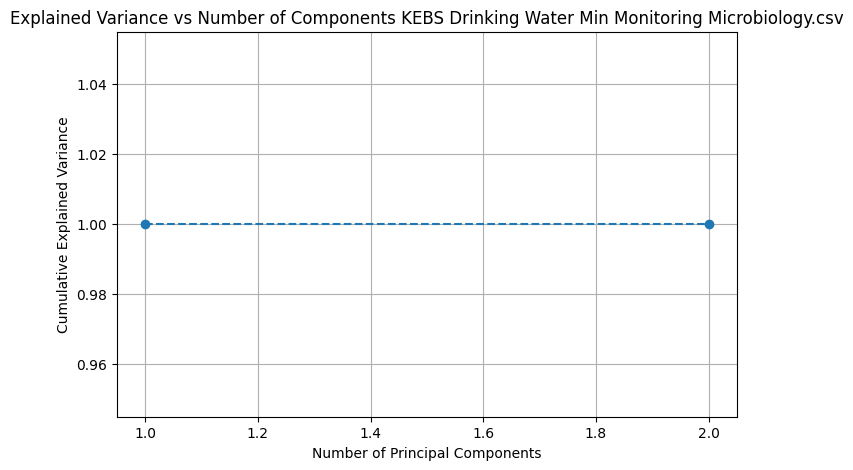

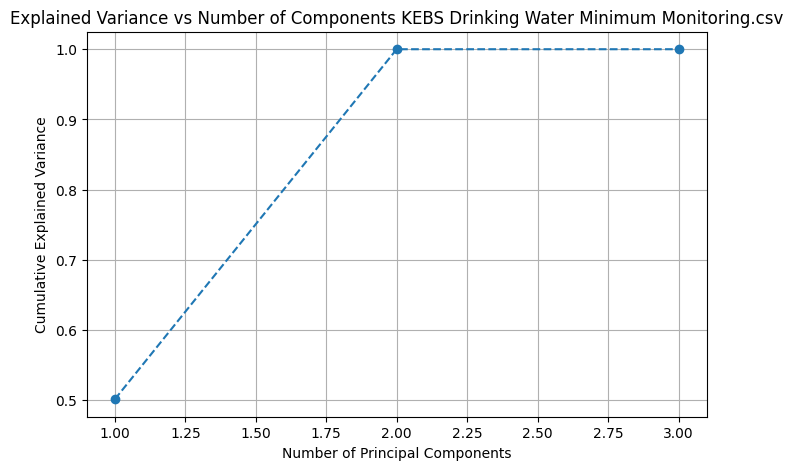

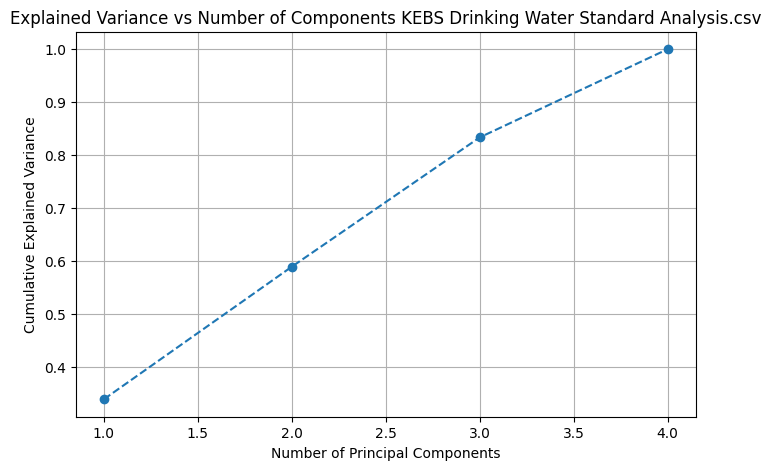

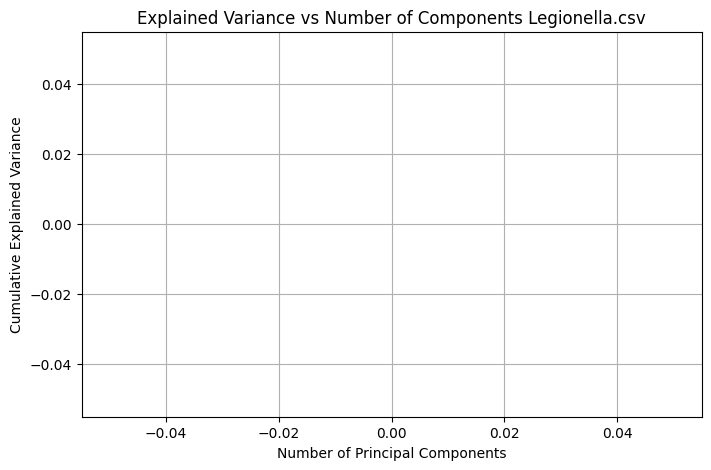

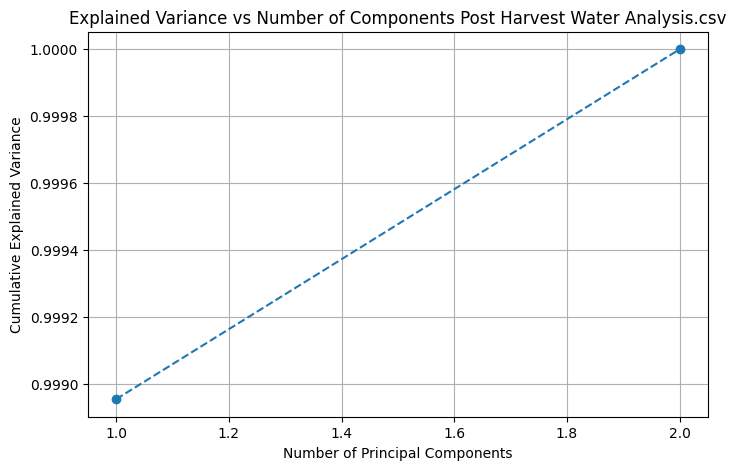

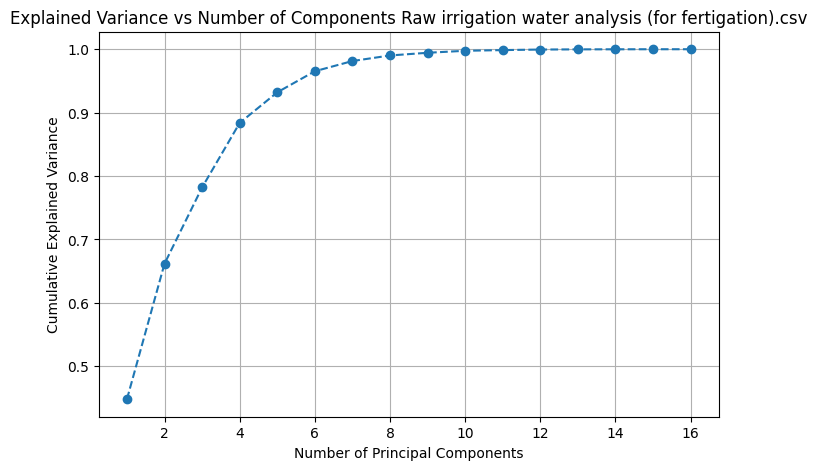

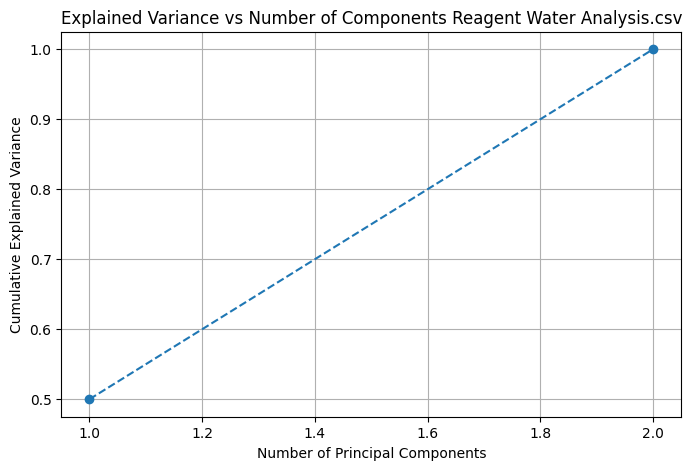

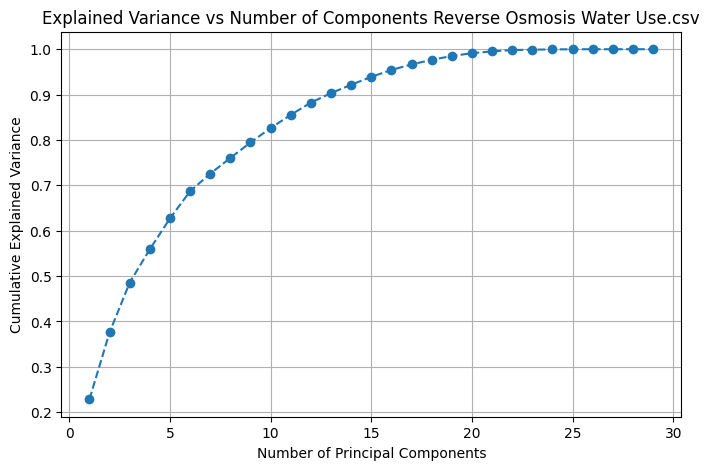

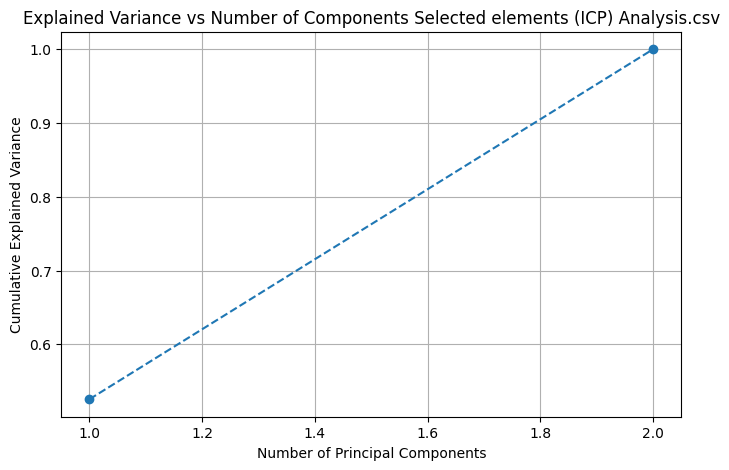

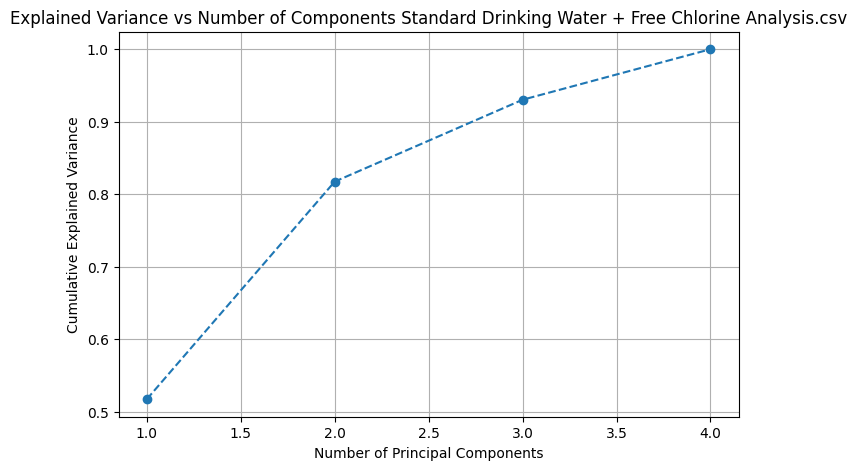

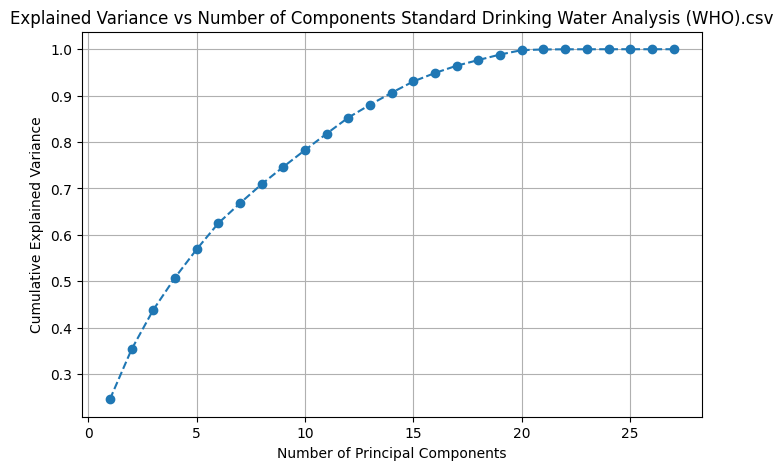

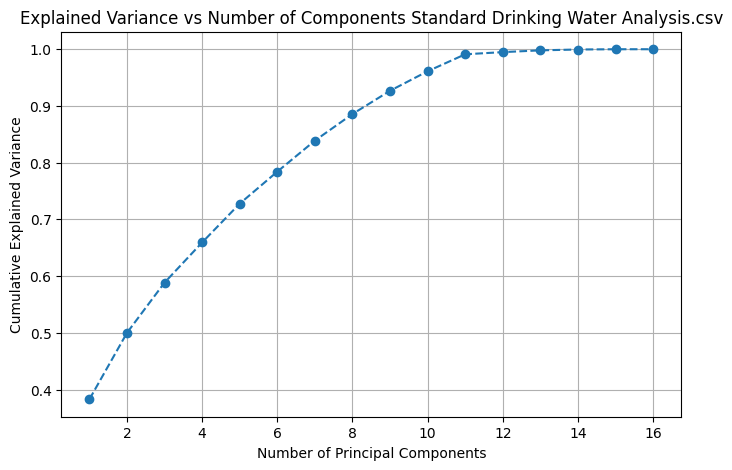

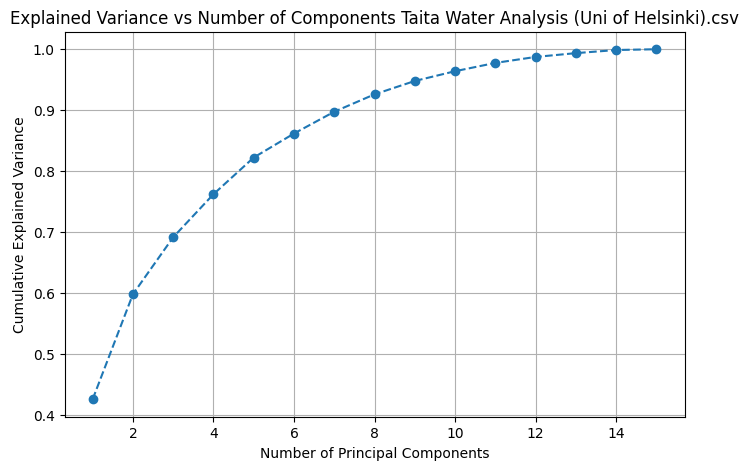

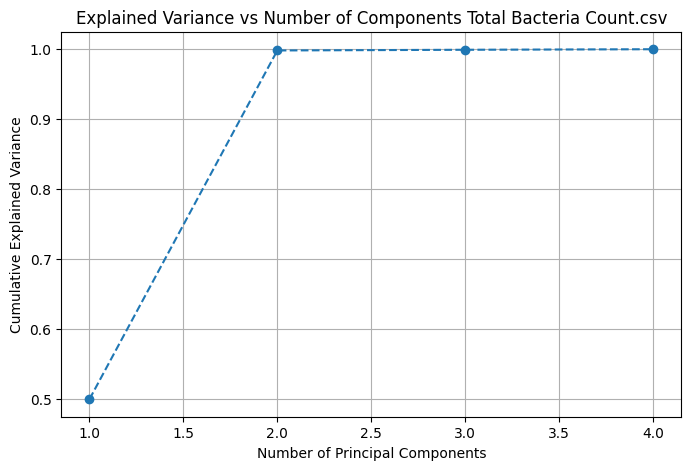

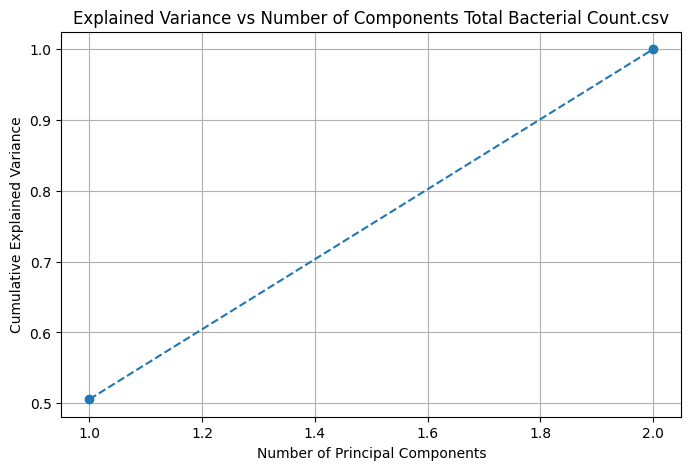

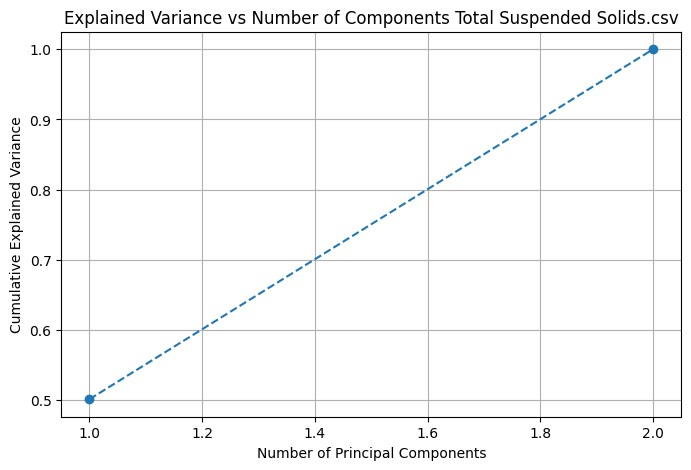

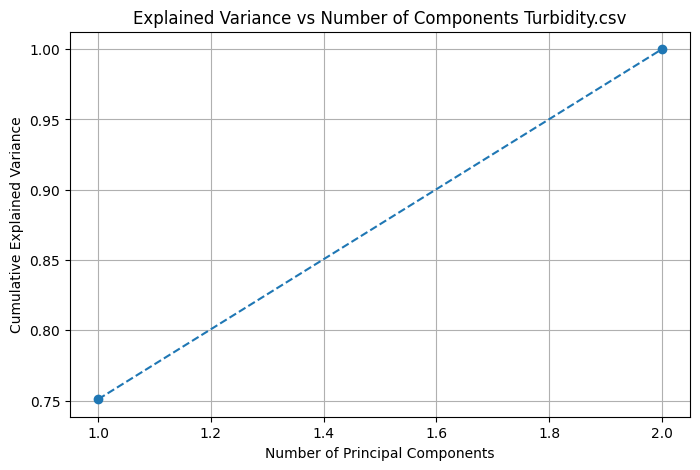

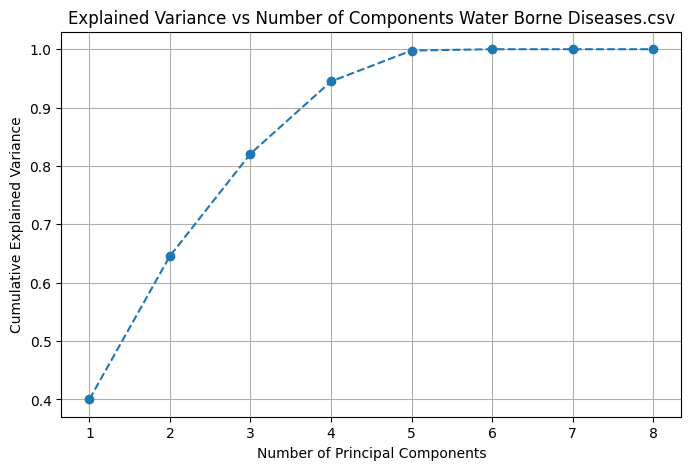

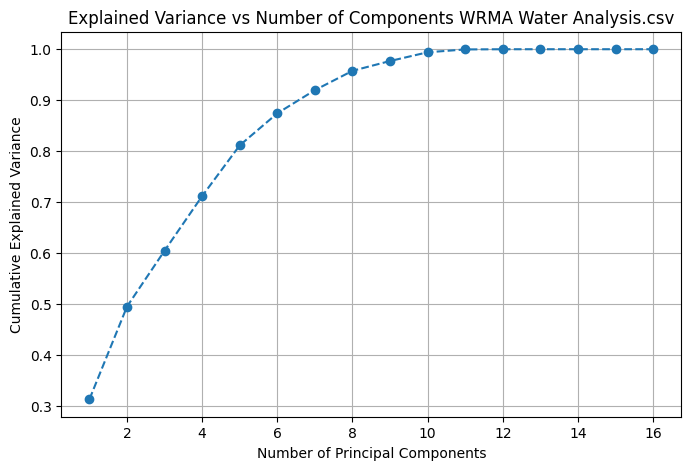

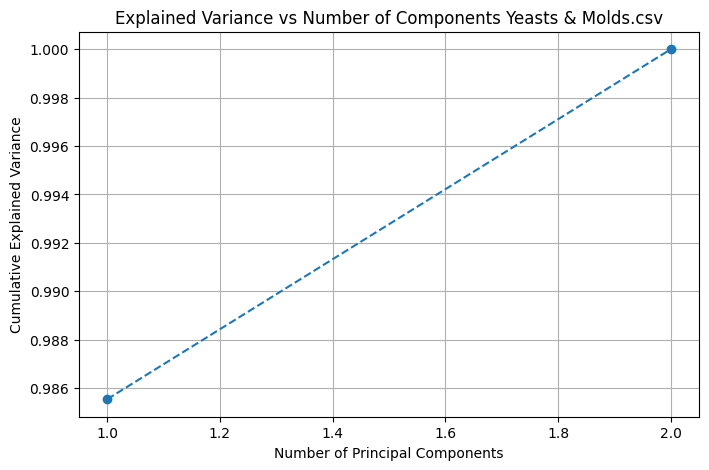

In [122]:
for analysis_file in os.listdir("output/analysis"):
    print(analysis_file)
    analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
    analysis_df = analysis_df.loc[analysis_df.index.isin(water_df.sample_code)]
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    # analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), columns=analysis_df.columns, index=analysis_df.index)
    analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), index=analysis_df.index)
    analysis_df.to_csv(f"./output/analysis_imputed/{analysis_file}")
    pickle.dump(imp_mean, open(f"models/imputers/{analysis_file.replace('csv','pkl')}","wb"))
    # if(len(analysis_df) == 0):
    #     continue
    if(len(analysis_df.columns) == 1):
        continue
    sc = StandardScaler()
    pca = PCA()
    analysis_scaled = sc.fit_transform(analysis_df)
    pca.fit(analysis_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Explained Variance vs Number of Components {analysis_file}')
    plt.grid(True)
    plt.savefig(f"./output/pca_plots/{analysis_file.replace('.csv','.png')}")
    n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
    print(f'Number of components explaining 95% variance: {n_components}')
    
    pca = PCA(n_components=n_components)
    pca_reduced_df = pca.fit_transform(analysis_scaled)
    analysis_scaled = pd.DataFrame(analysis_scaled,index=analysis_df.index)
    analysis_scaled.to_csv(f"output/analysis_scaled/{analysis_file}")
    np.save(f"output/pca_df/{analysis_file.replace('.csv','')}", pca_reduced_df)
    pickle.dump(sc, open(f"models/scalers/{analysis_file.replace('csv','pkl')}","wb"))
    pickle.dump(pca, open(f"models/pca/{analysis_file.replace('csv','pkl')}","wb"))

In [123]:
analysis_scaled

0         1
sample_code                    
CC010WA0001 -0.257593 -0.316028
CC010WA0002 -0.257593 -0.316028
CD048WA0036  0.000000 -0.316028
CD048WA0037  0.000000 -0.198187
CD048WA0038 -0.257593 -0.316028
CD048WA0039 -0.257593 -0.316028
CD048WA0040 -0.257593 -0.316028
CD048WA0041 -0.257593 -0.316028
CD048WA0042 -0.257593 -0.316028
CD048WA0043 -0.257593 -0.316028
CD048WA0044  0.075981  0.921302
CD048WA0045 -0.257593  0.273177
CD048WA0046 -0.257593 -0.316028
CD048WA0047 -0.257593 -0.316028
CD048WA0048 -0.257593 -0.021426
CD048WA0049 -0.257593 -0.316028
CD048WA0057 -0.257593 -0.316028
CD048WA0058 -0.257593 -0.316028
CD048WA0062 -0.257593 -0.316028
CD048WA0063 -0.257593 -0.316028
CS081WA0031 -0.257593 -0.316028
CS155WA0008  4.560686  4.397611

In [124]:
for analysis_file in os.listdir("output/pca_df"):
    print(analysis_file)
    pca_reduced_df = pd.DataFrame(np.load(f"output/pca_df/{analysis_file}"))
    if len(pca_reduced_df.columns) <= 2:
        continue
    mu = np.mean(pca_reduced_df, axis=0)
    sigma = np.cov(pca_reduced_df.T)
    pca_reduced_df['mahalanobis_distance'] = [distance.mahalanobis(pca_reduced_df.iloc[i], mu, np.linalg.inv(sigma)) for i in range(len(pca_reduced_df)) ]

    pd.DataFrame(pca_reduced_df).to_csv(f"output/mahalanobis_distance/{analysis_file.replace('.npy','')}.csv")

Aquasearch Full Chemical Analysis.npy
Base Titanium Water Analysis.npy
Basic Drinking Water Analysis (WHO).npy
Basic Drinking Water Analysis.npy
BT Extended Water Quality Analysis.npy
BTEX Analysis.npy
Chemical & Biochemical Oxygen Demand.npy
E coli & Total Coliforms.npy
Feacal Coliforms (MPN) and E.Coli.npy
Fluoride in Water.npy
Heavy Metals in Water.npy
Irrigation Water Analysis (FAO).npy
KEBS Drinking Water Microbiology.npy
KEBS Drinking Water Min Monitoring Microbiology.npy
KEBS Drinking Water Minimum Monitoring.npy
KEBS Drinking Water Standard Analysis.npy
Legionella.npy
Post Harvest Water Analysis.npy
Raw irrigation water analysis (for fertigation).npy
Reagent Water Analysis.npy
Reverse Osmosis Water Use.npy
Selected elements (ICP) Analysis.npy
Standard Drinking Water + Free Chlorine Analysis.npy
Standard Drinking Water Analysis (WHO).npy
Standard Drinking Water Analysis.npy
Taita Water Analysis (Uni of Helsinki).npy
Total Bacteria Count.npy
Total Bacterial Count.npy
Total Suspen

In [125]:
analysis_file

'Yeasts & Molds.npy'

In [126]:
mahalanobis_threshold_dict = {}
for analysis_file in os.listdir("output/mahalanobis_distance"):
    print(analysis_file)
    analysis = analysis_file.replace(".csv","")
    mahalanobis_df = pd.read_csv(f"output/mahalanobis_distance/{analysis_file}",index_col=0)
    upper_quantile = (mahalanobis_df['mahalanobis_distance'].quantile(0.95))
    mahalanobis_threshold_dict[analysis_file.replace(".csv","")] = upper_quantile
    mahalanobis_df.loc[mahalanobis_df['mahalanobis_distance'] >= upper_quantile].to_csv(f"output/mahanobis_distance_upper_quantile/{analysis_file}")
    plt.boxplot(mahalanobis_df['mahalanobis_distance'])
    plt.axhline(y=upper_quantile, color='red', linestyle='--', label=f'Threshold at {upper_quantile}')
    plt.title(f"Mahalanobis Threshold = {round(upper_quantile,2)}")
    plt.savefig(f"output/mahalanobis_boxplots/{analysis}.png")
    plt.clf()
pickle.dump(mahalanobis_threshold_dict, open("mahalanobis_thresholds.dict","wb"))

Base Titanium Water Analysis.csv
Basic Drinking Water Analysis (WHO).csv
Basic Drinking Water Analysis.csv
BT Extended Water Quality Analysis.csv
Heavy Metals in Water.csv
Irrigation Water Analysis (FAO).csv
KEBS Drinking Water Microbiology.csv
KEBS Drinking Water Standard Analysis.csv
Raw irrigation water analysis (for fertigation).csv
Reverse Osmosis Water Use.csv
Standard Drinking Water + Free Chlorine Analysis.csv
Standard Drinking Water Analysis (WHO).csv
Standard Drinking Water Analysis.csv
Taita Water Analysis (Uni of Helsinki).csv
Water Borne Diseases.csv
WRMA Water Analysis.csv


<Figure size 640x480 with 0 Axes>

In [127]:
pd.DataFrame({'analysis_name':(mahalanobis_threshold_dict.keys())}).to_csv("output/analysis_names_send_to_thomas_and_josephine.csv")

In [128]:
new_samples_df.analysis_name.unique()

array(['Standard Drinking Water Analysis (WHO)',
       'Irrigation Water Analysis (FAO)', 'Reverse Osmosis Water Use',
       'Basic Drinking Water Analysis (WHO)', 'Heavy Metals in Water',
       'E coli & Total Coliforms', 'Post Harvest Water Analysis',
       'Total Suspended Solids', 'Total Bacteria Count',
       'Total Dissolved Solids', 'KEBS Drinking Water Standard Analysis',
       'KEBS Drinking Water Microbiology',
       'Standard Drinking Water + Free Chlorine Analysis',
       'Turbidity Analysis', 'Water Colour Analysis',
       'WRMA Water Analysis', 'Water Borne Diseases',
       'Aquasearch Full Chemical Analysis', 'Legionella',
       'Alkalinity in Water', 'E coli',
       'KEBS Drinking Water Minimum Monitoring',
       'Chemical & Biochemical Oxygen Demand', 'Total coliforms',
       'Selected elements (ICP) Analysis', 'Salmonella spp',
       'Aluminium analysis', 'Fluoride in Water',
       'Chemical Oxygen Demand',
       'KEBS Drinking Water Min Monitoring Mi

In [129]:
conn_lims = pyodbc.connect("Driver={SQL Server};"
                            "Server=192.168.5.18\CROPNUT;"
                            "Database=cropnuts;"
                            "uid=thomasTsuma;pwd=GR^KX$uRe9#JwLc6")

In [130]:
reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']
reverse_analysis_dict

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_32464\3771434913.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']


{'% Gypsum': 540,
 '% Nitrogen (RSSP 2)': 647,
 '% Organic Matter': 258,
 '% Organic Matter (RSSP 2)': 646,
 '% Soil Nitrogen': 18,
 '%Assay': 27490,
 '%N (RSSP 2)': 652,
 '%OM (RSSP 2)': 651,
 '%P,%S Analysis(Super Calcium)': 383,
 '1:2 Soil Volume Extract': 294,
 '1:2 soil volume extract': 25,
 '1:2 Soil Volume Extract (Data Only)': 27339,
 '1:2 Vol Extract for BLGG': 317,
 '20:12:12 (N,P205,K20) Analysis': 840,
 'Absorbance at 254nm': 26936,
 'Acid Detergent Fibre': 27063,
 'Acid Insoluble Ash': 27417,
 'Acid Insoluble Matter': 27108,
 'Acid titration': 26647,
 'Acid Value': 26971,
 'Advanced Biological Farming Soil Audit': 26521,
 'Advanced Soil Health Analysis': 27181,
 'Aerobic Mesophilic Count': 26649,
 'Aflatoxin': 26794,
 'Aflatoxin AFB1': 26938,
 'Aflatoxin B1': 26939,
 'Aflatoxin in feed': 767,
 'Aflatoxin M1': 27469,
 'Aflatoxin Total': 766,
 'AfSIS Standard Leaf Analysis': 633,
 'AFSIS Std Wet Chemistry Soil Analysis': 589,
 'Aggregate Stability': 26727,
 'Agrifi Soil Micr

In [131]:
len(reverse_analysis_dict.keys())

1348

In [132]:
len(new_samples_df[['sample_code','analysis_name']].value_counts())

3585

In [133]:
new_samples = pd.read_sql(f"SELECT sample_code, batch_date, result, unit_name, chemical_name, analysis_name FROM SampleResults WHERE sample_code IN {tuple(new_samples_df.sample_code.values)}", con=conn_lims)

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_32464\1881003016.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  new_samples = pd.read_sql(f"SELECT sample_code, batch_date, result, unit_name, chemical_name, analysis_name FROM SampleResults WHERE sample_code IN {tuple(new_samples_df.sample_code.values)}", con=conn_lims)


In [134]:
new_samples = new_samples.dropna(subset=['chemical_name','result','analysis_name'])
new_samples['analysis_name'] = [ str(i).replace(":","").split(",") for i in new_samples.analysis_name ]
new_samples = new_samples.explode("analysis_name")

In [135]:
new_samples

sample_code          batch_date  result unit_name  \
16           CB387WA0006 2024-05-21 09:32:00    0.17       ppm   
17           CT426WA0002 2024-07-19 16:11:00  < 0.01       ppm   
18           CI042WA0779 2024-07-26 12:22:00    16.3       ppm   
19     CH006WA2397       2024-08-16 08:31:00    0.03    mmol/l   
20     CB057WA2751       2024-08-21 11:53:00    5.18       ppm   
...                  ...                 ...     ...       ...   
71159        CB361WA0209 2024-09-12 17:14:00    0.72  mS cm -1   
71160        CB361WA0209 2024-09-12 17:14:00    43.3       ppm   
71160        CB361WA0209 2024-09-12 17:14:00    43.3       ppm   
71161        CB361WA0209 2024-09-12 17:14:00    92.6       ppm   
71161        CB361WA0209 2024-09-12 17:14:00    92.6       ppm   

                 chemical_name  \
16                        Zinc   
17                  Molybdenum   
18                 Bicarbonate   
19                    Ammonium   
20                    Nitrates   
...                        ...   
71159  Electrical Conductivity   
71160                Silicon     
71160                Silicon     
71161                   Silica   
71161                   Silica   

                                          analysis_name  
16               Standard Drinking Water Analysis (WHO)  
17                  Basic Drinking Water Analysis (WHO)  
18     Standard Drinking Water + Free Chlorine Analysis  
19                      Irrigation Water Analysis (FAO)  
20                                  WRMA Water Analysis  
...                                                 ...  
71159            Standard Drinking Water Analysis (WHO)  
71160                                Aluminium analysis  
71160            Standard Drinking Water Analysis (WHO)  
71161                                Aluminium analysis  
71161            Standard Drinking Water Analysis (WHO)  

[91910 rows x 6 columns]

In [136]:
new_samples['result'] = [ str(i).replace("<","").replace(">","").strip() for i in new_samples['result'] ]

In [137]:
new_samples.loc[(new_samples['result'] == "ND"), "result" ] = 0

In [138]:
new_samples = new_samples.loc[~(new_samples['result'] == "Detected") ]

In [139]:
new_samples

sample_code          batch_date result unit_name  \
16           CB387WA0006 2024-05-21 09:32:00   0.17       ppm   
17           CT426WA0002 2024-07-19 16:11:00   0.01       ppm   
18           CI042WA0779 2024-07-26 12:22:00   16.3       ppm   
19     CH006WA2397       2024-08-16 08:31:00   0.03    mmol/l   
20     CB057WA2751       2024-08-21 11:53:00   5.18       ppm   
...                  ...                 ...    ...       ...   
71159        CB361WA0209 2024-09-12 17:14:00   0.72  mS cm -1   
71160        CB361WA0209 2024-09-12 17:14:00   43.3       ppm   
71160        CB361WA0209 2024-09-12 17:14:00   43.3       ppm   
71161        CB361WA0209 2024-09-12 17:14:00   92.6       ppm   
71161        CB361WA0209 2024-09-12 17:14:00   92.6       ppm   

                 chemical_name  \
16                        Zinc   
17                  Molybdenum   
18                 Bicarbonate   
19                    Ammonium   
20                    Nitrates   
...                        ...   
71159  Electrical Conductivity   
71160                Silicon     
71160                Silicon     
71161                   Silica   
71161                   Silica   

                                          analysis_name  
16               Standard Drinking Water Analysis (WHO)  
17                  Basic Drinking Water Analysis (WHO)  
18     Standard Drinking Water + Free Chlorine Analysis  
19                      Irrigation Water Analysis (FAO)  
20                                  WRMA Water Analysis  
...                                                 ...  
71159            Standard Drinking Water Analysis (WHO)  
71160                                Aluminium analysis  
71160            Standard Drinking Water Analysis (WHO)  
71161                                Aluminium analysis  
71161            Standard Drinking Water Analysis (WHO)  

[91910 rows x 6 columns]

In [140]:
new_samples['unit_name'] = [ str(i).strip() for i in new_samples['unit_name'].values ]

In [141]:
new_samples['chemical_name'] = [ str(i).lower().replace(" ","_").replace("(","").replace(")","").replace(".","").strip() for i in new_samples['chemical_name'].values ]

In [142]:
new_samples['result'] = new_samples['result'].astype(float)

In [143]:
test = []

In [144]:
for sample in new_samples.sample_code.unique():
    res = {}
    tmp_ = new_samples.loc[new_samples.sample_code == sample]
    res['sample_code'] = sample
    print([ i for i in tmp_.analysis_name.unique() ])
    res['analysis_id'] = [ reverse_analysis_dict[i] for i in tmp_.analysis_name.unique() if i in reverse_analysis_dict.keys() ]
    for index,row in tmp_.iterrows():
        if row['result'] >= 0 :
            res[row['chemical_name']] = {'result': float(row['result']), 'units': str(row['unit_name'])}
        else:
            res[row['chemical_name']] = {'result': 0, 'units': row['unit_name']}
    test.append(res)    


['Standard Drinking Water Analysis (WHO)']
['Basic Drinking Water Analysis (WHO)']
['Standard Drinking Water + Free Chlorine Analysis']
['Irrigation Water Analysis (FAO)']
['WRMA Water Analysis']
['KEBS Drinking Water Minimum Monitoring', 'Total coliforms']
['Standard Drinking Water Analysis (WHO)']
['Basic Drinking Water Analysis (WHO)', 'Heavy Metals in Water', 'Total Dissolved Solids']
['Standard Drinking Water Analysis (WHO)']
['Basic Drinking Water Analysis (WHO)', 'Heavy Metals in Water', 'Total Dissolved Solids']
['Post Harvest Water Analysis']
['Reverse Osmosis Water Use']
['Irrigation Water Analysis (FAO)']
['Post Harvest Water Analysis']
['Irrigation Water Analysis (FAO)']
['Standard Drinking Water + Free Chlorine Analysis']
['Basic Drinking Water Analysis (WHO)']
['Standard Drinking Water Analysis (WHO)']
['WRMA Water Analysis']
['KEBS Drinking Water Minimum Monitoring', 'Total coliforms']
['Standard Drinking Water Analysis (WHO)']
['WRMA Water Analysis']
['Basic Drinking Wa

In [145]:
test

[{'sample_code': 'CB387WA0006',
  'analysis_id': [707],
  'zinc': {'result': 0.17, 'units': 'ppm'},
  'copper': {'result': 0.01, 'units': 'ppm'},
  'boron': {'result': 0.01, 'units': 'ppm'},
  'chloride': {'result': 5.54, 'units': 'ppm'},
  'bicarbonate': {'result': 35.0, 'units': 'ppm'},
  'fluoride': {'result': 0.22, 'units': 'ppm'},
  'molybdenum': {'result': 0.01, 'units': 'ppm'},
  'nitrates': {'result': 3.81, 'units': 'ppm'},
  'sulphate': {'result': 15.8, 'units': 'ppm'},
  'phosphate': {'result': 0.037, 'units': 'ppm'},
  'hardness': {'result': 22.4, 'units': 'ppm'},
  'turbidity': {'result': 1.64, 'units': 'NTU'},
  'e_coli': {'result': 0.0, 'units': 'cfu/100 ml'},
  'total_coliforms': {'result': 25.0, 'units': 'cfu/100 ml'},
  'ph': {'result': 7.48, 'units': 'None'},
  'electrical_conductivity': {'result': 0.12, 'units': 'mS cm -1'},
  'silicon__': {'result': 6.55, 'units': 'ppm'},
  'silica': {'result': 14.0, 'units': 'ppm'},
  'ammonium': {'result': 0.01, 'units': 'ppm'},
 

In [146]:
str(test).replace("'", '"')

'[{"sample_code": "CB387WA0006", "analysis_id": [707], "zinc": {"result": 0.17, "units": "ppm"}, "copper": {"result": 0.01, "units": "ppm"}, "boron": {"result": 0.01, "units": "ppm"}, "chloride": {"result": 5.54, "units": "ppm"}, "bicarbonate": {"result": 35.0, "units": "ppm"}, "fluoride": {"result": 0.22, "units": "ppm"}, "molybdenum": {"result": 0.01, "units": "ppm"}, "nitrates": {"result": 3.81, "units": "ppm"}, "sulphate": {"result": 15.8, "units": "ppm"}, "phosphate": {"result": 0.037, "units": "ppm"}, "hardness": {"result": 22.4, "units": "ppm"}, "turbidity": {"result": 1.64, "units": "NTU"}, "e_coli": {"result": 0.0, "units": "cfu/100 ml"}, "total_coliforms": {"result": 25.0, "units": "cfu/100 ml"}, "ph": {"result": 7.48, "units": "None"}, "electrical_conductivity": {"result": 0.12, "units": "mS cm -1"}, "silicon__": {"result": 6.55, "units": "ppm"}, "silica": {"result": 14.0, "units": "ppm"}, "ammonium": {"result": 0.01, "units": "ppm"}, "calcium": {"result": 6.29, "units": "pp

In [147]:
reverse_analysis_dict[ 'KEBS Drinking Water Microbiology']

26724

In [148]:
new_samples.analysis_name.unique()

array(['Standard Drinking Water Analysis (WHO)',
       'Basic Drinking Water Analysis (WHO)',
       'Standard Drinking Water + Free Chlorine Analysis',
       'Irrigation Water Analysis (FAO)', 'WRMA Water Analysis',
       'KEBS Drinking Water Minimum Monitoring', 'Total coliforms',
       'Heavy Metals in Water', 'Total Dissolved Solids',
       'Post Harvest Water Analysis', 'Reverse Osmosis Water Use',
       'KEBS Drinking Water Microbiology',
       'KEBS Drinking Water Standard Analysis',
       'E coli & Total Coliforms', 'E coli', 'Salmonella spp',
       'Total Bacteria Count', 'Yeast & Mould', 'pH in Water',
       'Total Silica in Water', 'Total Suspended Solids',
       'Water Quality Analysis (JF)', 'Aluminium analysis', 'Legionella',
       'Staphylococcus aureus', 'Listeria monocytogens',
       'Water Colour Analysis', 'Alkalinity in Water',
       'Chemical Oxygen Demand', 'Total Chlorine', 'Chloride in Water',
       'Fluoride in Water', 'Aquasearch Full Chemical A

In [149]:
import psycopg2

conn_lims = pyodbc.connect("Driver={SQL Server};"
                            "Server=192.168.5.18\CROPNUT;"
                            "Database=cropnuts;"
                            "uid=thomasTsuma;pwd=GR^KX$uRe9#JwLc6")

In [150]:
analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']


C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_32464\3258811639.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']


In [151]:
analysis_dict

{540: '% Gypsum',
 647: '% Nitrogen (RSSP 2)',
 258: '% Organic Matter',
 646: '% Organic Matter (RSSP 2)',
 18: '% Soil Nitrogen',
 27235: '%Assay',
 27490: '%Assay',
 652: '%N (RSSP 2)',
 651: '%OM (RSSP 2)',
 383: '%P,%S Analysis(Super Calcium)',
 294: '1:2 Soil Volume Extract',
 25: '1:2 soil volume extract',
 27339: '1:2 Soil Volume Extract (Data Only)',
 317: '1:2 Vol Extract for BLGG',
 840: '20:12:12 (N,P205,K20) Analysis',
 26936: 'Absorbance at 254nm',
 27063: 'Acid Detergent Fibre',
 27146: 'Acid Insoluble Ash',
 27003: 'Acid Insoluble Ash',
 27417: 'Acid Insoluble Ash',
 27108: 'Acid Insoluble Matter',
 26647: 'Acid titration',
 26971: 'Acid Value',
 26521: 'Advanced Biological Farming Soil Audit',
 27181: 'Advanced Soil Health Analysis',
 26649: 'Aerobic Mesophilic Count',
 26794: 'Aflatoxin',
 26938: 'Aflatoxin AFB1',
 26939: 'Aflatoxin B1',
 767: 'Aflatoxin in feed',
 27469: 'Aflatoxin M1',
 26753: 'Aflatoxin Total',
 766: 'Aflatoxin Total',
 633: 'AfSIS Standard Leaf An

In [152]:
pickle.dump(analysis_dict, open("analysis.dict","wb"))

In [153]:
analysis_dict = pickle.load(open("analysis.dict","rb"))

In [154]:
analysis_dict

{540: '% Gypsum',
 647: '% Nitrogen (RSSP 2)',
 258: '% Organic Matter',
 646: '% Organic Matter (RSSP 2)',
 18: '% Soil Nitrogen',
 27235: '%Assay',
 27490: '%Assay',
 652: '%N (RSSP 2)',
 651: '%OM (RSSP 2)',
 383: '%P,%S Analysis(Super Calcium)',
 294: '1:2 Soil Volume Extract',
 25: '1:2 soil volume extract',
 27339: '1:2 Soil Volume Extract (Data Only)',
 317: '1:2 Vol Extract for BLGG',
 840: '20:12:12 (N,P205,K20) Analysis',
 26936: 'Absorbance at 254nm',
 27063: 'Acid Detergent Fibre',
 27146: 'Acid Insoluble Ash',
 27003: 'Acid Insoluble Ash',
 27417: 'Acid Insoluble Ash',
 27108: 'Acid Insoluble Matter',
 26647: 'Acid titration',
 26971: 'Acid Value',
 26521: 'Advanced Biological Farming Soil Audit',
 27181: 'Advanced Soil Health Analysis',
 26649: 'Aerobic Mesophilic Count',
 26794: 'Aflatoxin',
 26938: 'Aflatoxin AFB1',
 26939: 'Aflatoxin B1',
 767: 'Aflatoxin in feed',
 27469: 'Aflatoxin M1',
 26753: 'Aflatoxin Total',
 766: 'Aflatoxin Total',
 633: 'AfSIS Standard Leaf An

In [155]:
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

In [156]:
pd.DataFrame({'analysis_name':mahalanobis_thresholds.keys()}).to_csv("output/analyses_in_models.csv")

In [157]:
unit_decision = pd.read_csv("output/water_unit_per_chemical_decision.csv")

In [158]:
unit_decision

Unnamed: 0                           analysis_name    chemical_name  \
0             0  Standard Drinking Water Analysis (WHO)  total_coliforms   
1             0  Standard Drinking Water Analysis (WHO)           e_coli   
2             0  Standard Drinking Water Analysis (WHO)          calcium   
3             0  Standard Drinking Water Analysis (WHO)             zinc   
4             0  Standard Drinking Water Analysis (WHO)        manganese   
..          ...                                     ...              ...   
449           0                           BTEX Analysis    ethyl_benzene   
450           0                           BTEX Analysis        benzene__   
451           0                           BTEX Analysis          xylene_   
452           0                           BTEX Analysis         toluene_   
453           0           Salmonella and E.Coli (Water)           e_coli   

      unit_name  
0     mpn/100ml  
1     mpn/100ml  
2           ppm  
3           ppm  
4           ppm  
..          ...  
449        ug/l  
450        ug/l  
451        ug/l  
452        ug/l  
453  cfu/100 ml  

[454 rows x 4 columns]

In [159]:
unit_decision.loc[unit_decision['analysis_name'] == 'Total Silica in Water']

Empty DataFrame
Columns: [Unnamed: 0, analysis_name, chemical_name, unit_name]
Index: []

In [160]:
req_body = test
_ = pd.DataFrame(req_body)
unit_decision = pd.read_csv("output/water_unit_per_chemical_decision.csv")
analysis_dict = pickle.load(open("analysis.dict","rb"))
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

result = {}
_df = _.explode('analysis_id', ignore_index=True)

In [161]:
mahalanobis_thresholds

{'Base Titanium Water Analysis': 5.235458707502789,
 'Basic Drinking Water Analysis (WHO)': 4.5046761049057515,
 'Basic Drinking Water Analysis': 6.124900398359228,
 'BT Extended Water Quality Analysis': 5.757549370626824,
 'Heavy Metals in Water': 3.3161160961470566,
 'Irrigation Water Analysis (FAO)': 5.765520601414945,
 'KEBS Drinking Water Microbiology': 4.766777583672856,
 'KEBS Drinking Water Standard Analysis': 2.53192261065579,
 'Raw irrigation water analysis (for fertigation)': 5.2092883308803675,
 'Reverse Osmosis Water Use': 5.541701924640433,
 'Standard Drinking Water + Free Chlorine Analysis': 3.3863461778526633,
 'Standard Drinking Water Analysis (WHO)': 5.736249621826848,
 'Standard Drinking Water Analysis': 4.519902149013585,
 'Taita Water Analysis (Uni of Helsinki)': 6.319007383015461,
 'Water Borne Diseases': 5.178861753334715,
 'WRMA Water Analysis': 6.0888879253258565}

In [162]:
for index,row in _df.iterrows():
    print(row.dropna().index)
    break

Index(['sample_code', 'analysis_id', 'zinc', 'copper', 'boron', 'chloride',
       'bicarbonate', 'fluoride', 'molybdenum', 'nitrates', 'sulphate',
       'phosphate', 'hardness', 'turbidity', 'e_coli', 'total_coliforms', 'ph',
       'electrical_conductivity', 'silicon__', 'silica', 'ammonium', 'calcium',
       'magnesium', 'potassium', 'sodium', 'nitrate_n', 'phosphorus',
       'sulphur', 'iron', 'manganese'],
      dtype='object')


In [178]:
_df

sample_code analysis_id                                 zinc  \
0           CB387WA0006         707     {'result': 0.17, 'units': 'ppm'}   
1           CT426WA0002         288     {'result': 0.01, 'units': 'ppm'}   
2           CI042WA0779       26691     {'result': 0.01, 'units': 'ppm'}   
3     CH006WA2397             27008  {'result': 1.53, 'units': 'µmol/l'}   
4     CB057WA2751             27056                                  NaN   
...                 ...         ...                                  ...   
3909        CB361WA0209         707    {'result': 0.034, 'units': 'ppm'}   
3910        CB361WA0210       27131    {'result': 0.036, 'units': 'ppm'}   
3911        CB361WA0210         707    {'result': 0.036, 'units': 'ppm'}   
3912        CB361WA0211       27131     {'result': 0.04, 'units': 'ppm'}   
3913        CB361WA0211         707     {'result': 0.04, 'units': 'ppm'}   

                                   copper  \
0        {'result': 0.01, 'units': 'ppm'}   
1       {'result': 0.013, 'units': 'ppm'}   
2        {'result': 0.01, 'units': 'ppm'}   
3     {'result': 0.16, 'units': 'µmol/l'}   
4                                     NaN   
...                                   ...   
3909     {'result': 0.01, 'units': 'ppm'}   
3910     {'result': 0.01, 'units': 'ppm'}   
3911     {'result': 0.01, 'units': 'ppm'}   
3912     {'result': 0.01, 'units': 'ppm'}   
3913     {'result': 0.01, 'units': 'ppm'}   

                                    boron                            chloride  \
0        {'result': 0.01, 'units': 'ppm'}    {'result': 5.54, 'units': 'ppm'}   
1        {'result': 0.57, 'units': 'ppm'}    {'result': 27.8, 'units': 'ppm'}   
2         {'result': 0.1, 'units': 'ppm'}    {'result': 7.77, 'units': 'ppm'}   
3     {'result': 20.4, 'units': 'µmol/l'}  {'result': 0.3, 'units': 'mmol/l'}   
4                                     NaN    {'result': 22.0, 'units': 'ppm'}   
...                                   ...                                 ...   
3909    {'result': 0.024, 'units': 'ppm'}    {'result': 17.7, 'units': 'ppm'}   
3910    {'result': 0.021, 'units': 'ppm'}    {'result': 17.4, 'units': 'ppm'}   
3911    {'result': 0.021, 'units': 'ppm'}    {'result': 17.4, 'units': 'ppm'}   
3912    {'result': 0.024, 'units': 'ppm'}    {'result': 17.6, 'units': 'ppm'}   
3913    {'result': 0.024, 'units': 'ppm'}    {'result': 17.6, 'units': 'ppm'}   

                              bicarbonate                           fluoride  \
0        {'result': 35.0, 'units': 'ppm'}   {'result': 0.22, 'units': 'ppm'}   
1        {'result': 52.4, 'units': 'ppm'}   {'result': 0.03, 'units': 'ppm'}   
2        {'result': 16.3, 'units': 'ppm'}   {'result': 0.09, 'units': 'ppm'}   
3     {'result': 1.48, 'units': 'mmol/l'}                                NaN   
4                                     NaN  {'result': 0.039, 'units': 'ppm'}   
...                                   ...                                ...   
3909    {'result': 434.0, 'units': 'ppm'}   {'result': 1.73, 'units': 'ppm'}   
3910    {'result': 440.0, 'units': 'ppm'}   {'result': 1.67, 'units': 'ppm'}   
3911    {'result': 440.0, 'units': 'ppm'}   {'result': 1.67, 'units': 'ppm'}   
3912    {'result': 427.0, 'units': 'ppm'}   {'result': 1.69, 'units': 'ppm'}   
3913    {'result': 427.0, 'units': 'ppm'}   {'result': 1.69, 'units': 'ppm'}   

                              molybdenum                             nitrates  \
0       {'result': 0.01, 'units': 'ppm'}     {'result': 3.81, 'units': 'ppm'}   
1       {'result': 0.01, 'units': 'ppm'}      {'result': 2.3, 'units': 'ppm'}   
2       {'result': 0.01, 'units': 'ppm'}     {'result': 2.52, 'units': 'ppm'}   
3     {'result': 0.2, 'units': 'µmol/l'}  {'result': 0.27, 'units': 'mmol/l'}   
4                                    NaN     {'result': 5.18, 'units': 'ppm'}   
...                                  ...                                  ...   
3909    {'result': 0.01, 'units': 'ppm'}     {'result': 6

In [185]:
req_body = test
_ = pd.DataFrame(req_body)
unit_decision = pd.read_csv("output/water_unit_per_chemical_decision.csv")
analysis_dict = pickle.load(open("analysis.dict","rb"))
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

result = {}
_df = _.explode('analysis_id', ignore_index=True)
import math
for index,row in _df.iterrows():
    sample_code = row['sample_code']
    if sample_code not in result.keys():
        result[sample_code] = []
    if math.isnan(row['analysis_id']):
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in specified", "details": f"Analysis id not provided", "analysis": None  })   
        continue
    row['analysis_name'] = analysis_dict[row['analysis_id']]
    analysis = row['analysis_name']
    analysis_id = row['analysis_id']
    if analysis not in mahalanobis_thresholds.keys():
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in models", "details": f"Analysis: {analysis} is not in the list of defined models", "analysis": row['analysis_name'] })   
        continue  
    row = row.dropna()
    scaler = pickle.load(open(f"models/scalers/{analysis}.pkl","rb"))
    pca = pickle.load(open(f"models/pca/{analysis}.pkl","rb"))
    imputer = pickle.load(open(f"models/imputers/{analysis}.pkl","rb"))
    analysis_df = pd.read_csv(f"output/analysis/{analysis}.csv",index_col=0)
    mahalanobis_distance_df = pd.read_csv(f"output/mahalanobis_distance/{analysis}.csv",index_col=0).drop("mahalanobis_distance",axis=1)

    

    try :
        tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    except Exception as e:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Missing parameters for analysis: {analysis}", "details": f"Missing parameters: {','.join([ i for i in analysis_df.columns if i not in row.dropna().index])} for analysis: {analysis}", "analysis": row['analysis_name']})
        continue
    failed_units_comparison = {}    
    for col in tmp_df.columns:
        expected_units = unit_decision.loc[(unit_decision['analysis_name'] == analysis) & (unit_decision['chemical_name'] == col)]
        expected_units = expected_units.fillna("None")
        import math
        if type(row[col]) != dict and math.isnan(row[col]):
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = None
        elif row[col]['units'] !=   expected_units['unit_name'].values[0] :
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = row[col]['units']
        else:
            continue    
    if len(failed_units_comparison.keys()) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Wrong units provided", "details": f"Expected units are {str(failed_units_comparison)} for analysis: {analysis}" , "analysis": row['analysis_name']})
        continue
    for col in analysis_df.columns:
        if type(row[col]) == dict:
            row[col] = row[col]['result']
    
    out_of_bounds_chems = [ ]
    for col in tmp_df.columns:
        if col == "sample_code":
            continue
        if col == "ec_salts":
            if row[col] > 105 or row[col] < 95:
                out_of_bounds_chems.append("ec_salts out of bounds. Allowed bounds are 95 - 105")
        if col == "Charge Balance":
            if row[col] < -1:
                out_of_bounds_chems.append("Charge Balance out of bounds. Allowed lower boundary is -10. ")       
        elif col.lower() == "total suspended solids" and row['analysis_name'].lower() == "total suspended solids":
            if row[col] > 1:
                out_of_bounds_chems.append("total suspended solids out of bounds. If analysis is total suspended solids is <1 then total suspended solids check should be <1  . ")         
    if len(out_of_bounds_chems) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Out of bounds", "details": f"{'.'.join(out_of_bounds_chems)}", "analysis": row['analysis_name'] })
        continue    

    tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    tmp_df = imputer.transform(tmp_df)
    df_scaled = scaler.transform(tmp_df)
    df_pca = pd.DataFrame(pca.transform(df_scaled))
    
    df_pca.columns = [ i for i in df_pca.columns]
    mahalanobis_distance_df.columns = [ i for i in df_pca.columns]
    df_pca = pd.concat([df_pca, mahalanobis_distance_df])
    mu = np.mean(df_pca, axis=0)
    sigma = np.cov(df_pca.T)

    mahalanobis_distance = distance.mahalanobis(df_pca.iloc[0], mu, np.linalg.inv(sigma))

    expected_md = mahalanobis_thresholds[analysis]

    if mahalanobis_distance > expected_md:
        result[sample_code].append({"sample_code": sample_code,"status":"fail", "message": "Mahalanobis distance exceeds threshold", "details":f"Mahalanobis distance of {round(mahalanobis_distance,2)} exceeds threshold of {round(expected_md,2)} for analysis: {analysis}", "analysis": row['analysis_name'] })
    else:
        result[sample_code].append({"sample_code": sample_code,"status":"pass","message": "Mahalanobis distance within threshold", "details":f"Mahalanobis distance of {round(mahalanobis_distance,2)} is within threshold of {round(expected_md,2)} for analysis: {analysis}", "analysis": row['analysis_name'] })
          


KeyboardInterrupt



In [ ]:

result

In [ ]:
mahalanobis_thresholds

In [ ]:
test

In [ ]:
final_df = pd.DataFrame()
for i in result.keys():
    out_df = (pd.DataFrame(result[i]))
    final_df = pd.concat([final_df, out_df])


In [184]:
final_df.to_csv("test_results.csv")

In [177]:
final_df

sample_code   status                                message  \
0         CB387WA0006  warning                   Wrong units provided   
0         CT426WA0002     pass  Mahalanobis distance within threshold   
0         CI042WA0779  warning                   Wrong units provided   
0   CH006WA2397        warning                   Wrong units provided   
0   CB057WA2751           pass  Mahalanobis distance within threshold   
..                ...      ...                                    ...   
1         CB361WA0209     pass  Mahalanobis distance within threshold   
0         CB361WA0210  warning                 Analysis not in models   
1         CB361WA0210     pass  Mahalanobis distance within threshold   
0         CB361WA0211  warning                 Analysis not in models   
1         CB361WA0211     pass  Mahalanobis distance within threshold   

                                              details  \
0   Expected units are {'e_coli': {'expected_units...   
0   Mahalanobis distance of 1.55 is within thresho...   
0   Expected units are {'total_coliforms': {'expec...   
0   Expected units are {'potassium': {'expected_un...   
0   Mahalanobis distance of 0.66 is within thresho...   
..                                                ...   
1   Mahalanobis distance of 2.24 is within thresho...   
0   Analysis: Aluminium analysis is not in the lis...   
1   Mahalanobis distance of 2.23 is within thresho...   
0   Analysis: Aluminium analysis is not in the lis...   
1   Mahalanobis distance of 2.21 is within thresho...   

                                            analysis  
0             Standard Drinking Water Analysis (WHO)  
0                Basic Drinking Water Analysis (WHO)  
0   Standard Drinking Water + Free Chlorine Analysis  
0                    Irrigation Water Analysis (FAO)  
0                                WRMA Water Analysis  
..                                               ...  
1             Standard Drinking Water Analysis (WHO)  
0                                 Aluminium analysis  
1             Standard Drinking Water Analysis (WHO)  
0                                 Aluminium analysis  
1             Standard Drinking Water Analysis (WHO)  

[3914 rows x 5 columns]

In [85]:
# pd.DataFrame([ result[i][0]  for i in result.keys()]).to_csv("test_results.csv")